## Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Import all code from previous notebooks

In [2]:
#export
from exp.nb_04 import *

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7013)

## Get the MNIST training and validation data sets

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
n_hidden,batch_size = 50,512
n_out = y_train.max().item()+1
loss_func = F.cross_entropy

### package the training and validation datasets into a DataBunch object

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, batch_size), n_out)

### export function that creates a learner object as a container for model, optimizer, loss_func, and data 

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

### instantiate learner and runner objects, and run the training loop

In [6]:
# instantiate a learner object
learn = create_learner(get_model, loss_func, data)
# instantiate a runner object
run = Runner([AvgStatsCallback([accuracy])])
# run the training loop
run.fit(learn, n_epochs=3)

train: [0.660294296875, tensor(0.8097)]
valid: [0.32929248046875, tensor(0.9012)]
train: [0.292488125, tensor(0.9156)]
valid: [0.2441741943359375, tensor(0.9305)]
train: [0.23673732421875, tensor(0.9321)]
valid: [0.198590771484375, tensor(0.9434)]


### instantiate learner and runner objects, and run the training loop again, this time with learning_rate = 0.3

In [7]:
# instantiate a learner object
learn = create_learner(partial(get_model, learning_rate=0.3), loss_func, data)
# instantiate a runner object
run = Runner([AvgStatsCallback([accuracy])])
# run the training loop for 3 epochs
run.fit(learn, n_epochs=3)

train: [0.77123984375, tensor(0.7951)]
valid: [0.369901708984375, tensor(0.8950)]
train: [0.3434974609375, tensor(0.9025)]
valid: [0.2914107666015625, tensor(0.9174)]
train: [0.29159759765625, tensor(0.9160)]
valid: [0.25248974609375, tensor(0.9277)]


### export partial get_model function that takes only a learning rate as input 

In [8]:
#export
def get_model_func(learning_rate=0.5): 
    return partial(get_model, learning_rate=learning_rate)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7202)

In [22]:
#export
class Recorder(Callback):
    def begin_fit(self): 
        self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    # ?????what is the function of the _order parameter?????
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            # pg[self.pname] = self.sched_func(self.n_epochs,self.epoch)
            print(self.epoch, self.n_epochs_float)
            pg[self.pname] = self.sched_func(self.n_epochs_float)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7431)

In [23]:
def sched_lin(start, end):
    def _inner(start, end, pos): 
        return start + pos*(end-start)
    return partial(_inner, start, end)

We can refactor this with a decorator.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7526)

In [24]:
#export
def annealer(f):
    def _inner(start, end): 
        return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): 
    return start + pos*(end-start)

In [25]:
# shift-tab works too, in Jupyter!
# sched_lin()

In [26]:
f = sched_lin(1,2)
f(0.3)

1.3

And here are other scheduler functions:

In [27]:
#export
@annealer
def sched_cos(start, end, pos): 
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  
    return start
@annealer
def sched_exp(start, end, pos): 
    return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7730)

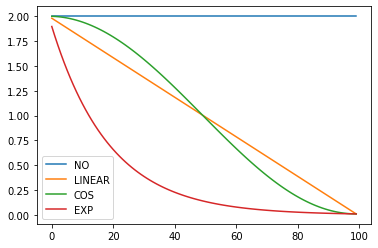

In [28]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [29]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [30]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

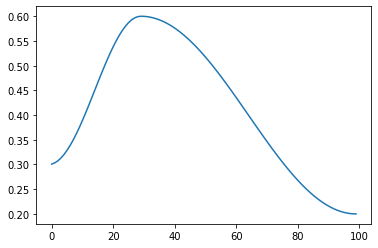

In [31]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...

In [32]:
callback_funcs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'learning_rate', sched)]

In [33]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(callback_funcs=callback_funcs)

In [34]:
# !!!!! scheduling not working yet
run.fit(learn, n_epochs = 3)

0 0.0
0 0.01020408163265306
0 0.02040816326530612
0 0.030612244897959183
0 0.04081632653061224
0 0.0510204081632653
0 0.06122448979591836
0 0.07142857142857142
0 0.08163265306122448
0 0.09183673469387754
0 0.1020408163265306
0 0.11224489795918366
0 0.12244897959183672
0 0.13265306122448978
0 0.14285714285714285
0 0.15306122448979592
0 0.163265306122449
0 0.17346938775510207
0 0.18367346938775514
0 0.1938775510204082
0 0.20408163265306128
0 0.21428571428571436
0 0.22448979591836743
0 0.2346938775510205
0 0.24489795918367357
0 0.25510204081632665
0 0.2653061224489797
0 0.2755102040816328
0 0.28571428571428586
0 0.29591836734693894
0 0.306122448979592
0 0.3163265306122451
0 0.32653061224489816
0 0.3367346938775512
0 0.3469387755102043
0 0.3571428571428574
0 0.36734693877551045
0 0.3775510204081635
0 0.3877551020408166
0 0.39795918367346966
0 0.40816326530612274
0 0.4183673469387758
0 0.4285714285714289
0 0.43877551020408195
0 0.448979591836735
0 0.4591836734693881
0 0.46938775510204117
0 

... then check with our recorder if the learning rate followed the right schedule.

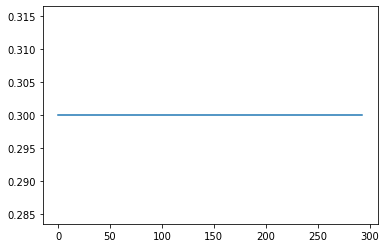

In [36]:
# !!!!! find the error in the scheduler
run.recorder.plot_lr()

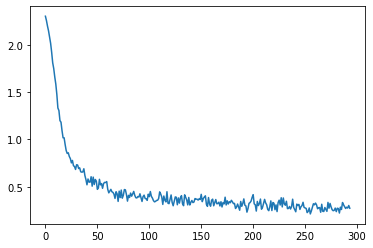

In [37]:
run.recorder.plot_loss()

## Export

In [38]:
!python notebook2script.py 05_anneal_jcat.ipynb

Converted 05_anneal_jcat.ipynb to exp\nb_05.py
